# Zeroshot with CLOOB

This notebook shows how to do zeroshot with pretrained CLOOB models.

The models and the datasets can be downloaded [here](https://ml.jku.at/research/CLOOB/downloads/).

In [5]:
import os
import sys

import json
import random
import glob

import numpy as np
import torch
import torchvision.datasets as datasets
from tqdm import tqdm
from sklearn.metrics import accuracy_score, balanced_accuracy_score

from PIL import Image

import matplotlib.pyplot as plt

import cloob.clip as clip
from cloob.clip import _transform
from cloob.model import CLIPGeneral
import cloob.zeroshot_data as zeroshot_data

# Set the GPU
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## Load checkpoint
Add the path of checkpoint here.

In [7]:
checkpoint_path = '../checkpoints/cloob_rn50_yfcc_epoch_28.pt'

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device is ", device)

checkpoint = torch.load(checkpoint_path, map_location=device)
model_config_file = os.path.join('./model_configs/', checkpoint['model_config_file'])

print('Loading model from', model_config_file)
assert os.path.exists(model_config_file)
with open(model_config_file, 'r') as f:
    model_info = json.load(f)
model = CLIPGeneral(**model_info)
preprocess= _transform(model.visual.input_resolution, is_train=False)

if not torch.cuda.is_available():
    model.float()
else:
    model.to(device)

sd = checkpoint["state_dict"]
sd = {k[len('module.'):]: v for k, v in sd.items()}
if 'logit_scale_hopfield' in sd:
    sd.pop('logit_scale_hopfield', None)
model.load_state_dict(sd)

Device is  cpu
Loading model from ./model_configs/RN50.json


<All keys matched successfully>

## Dataset
Add the path of the dataset you want to do evaluate.

In [9]:
data_path = '../data/gtsrb/test'
dataset = datasets.ImageFolder(data_path, transform=preprocess)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, num_workers=8)

## Zeroshot

In [10]:
def zero_shot_classifier(model, classnames, templates, device):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = [template(classname) for template in templates] #format with class
            texts = clip.tokenize(texts).to(device) #tokenize
            class_embeddings = model.encode_text(texts)
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).to(device)
    return zeroshot_weights

def run(model, classifier, dataloader, device, accuracy_metric):
    with torch.no_grad():
        all_logits = []
        all_targets = []
        for images, target in tqdm(dataloader):
            images = images.to(device)
            target = target.to(device)

            # predict
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            logits = image_features @ classifier

            all_logits.append(logits.cpu())
            all_targets.append(target.cpu())

        all_logits = torch.cat(all_logits).numpy()
        all_targets = torch.cat(all_targets).numpy()

        acc = accuracy_metric(all_targets, all_logits.argmax(axis=1)) * 100.0
        return acc

Define the classnames and prompt_templates here. 

For the provided datasets the original CLIP classnames and prompts can be found in [zeroshot_data.py](../training/zeroshot_data.py)

In [15]:
classnames = zeroshot_data.gtsrb_classnames
prompt_templates = zeroshot_data.gtsrb_templates

In [16]:
model.eval()
accuracy_metric = accuracy_score
print("Calculating the text embeddings for all classes of the dataset", flush=True)
classifier = zero_shot_classifier(model, classnames, prompt_templates, device)
print("Calculating the image embeddings for all images of the dataset", flush=True)
# accuracy = run(model, classifier, dataloader, device, accuracy_score)
# print('Zeroshot accuracy: ', accuracy.round(2))

Calculating the text embeddings for all classes of the dataset


100%|██████████| 43/43 [00:10<00:00,  4.03it/s]

Calculating the image embeddings for all images of the dataset


## Visualization of the results

This visualization shows the top 5 classification results for random images in the dataset.

In [11]:
def get_images(data_path, preprocess, count=8, seed=31415):
    random.seed(seed)
    class_folder_names = sorted(os.listdir(data_path))
    original_images = []
    processed_images = []
    image_labels = []
    all_image_paths = glob.glob(os.path.join(data_path, '*', '*'), recursive=True)
    select_image_paths = random.sample(all_image_paths, k=count)
    for image_path in select_image_paths:
        print(image_path)
        image_labels.append(class_folder_names.index(os.path.split(os.path.split(image_path)[0])[1]))
        with Image.open(image_path) as im:
            original_images.append(im)
            processed_images.append(preprocess(im))

    processed_images = torch.stack(processed_images)

    return original_images, processed_images, image_labels

In [21]:
original_images, processed_images, image_labels = get_images(data_path, preprocess)
model.eval()
images = processed_images.to(device)
with torch.no_grad():
    image_features = model.encode_image(images)
    image_features /= image_features.norm(dim=-1, keepdim=True)
text_probs = (30.0 * image_features @ classifier).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

top_probs = top_probs.cpu()
top_labels = top_labels.cpu()
text_probs = text_probs.cpu()

../data/gtsrb/test\025\10553.png
../data/gtsrb/test\009\08086.png
../data/gtsrb/test\014\00621.png
../data/gtsrb/test\001\11095.png
../data/gtsrb/test\022\03702.png
../data/gtsrb/test\018\10780.png
../data/gtsrb/test\013\05310.png
../data/gtsrb/test\004\02686.png


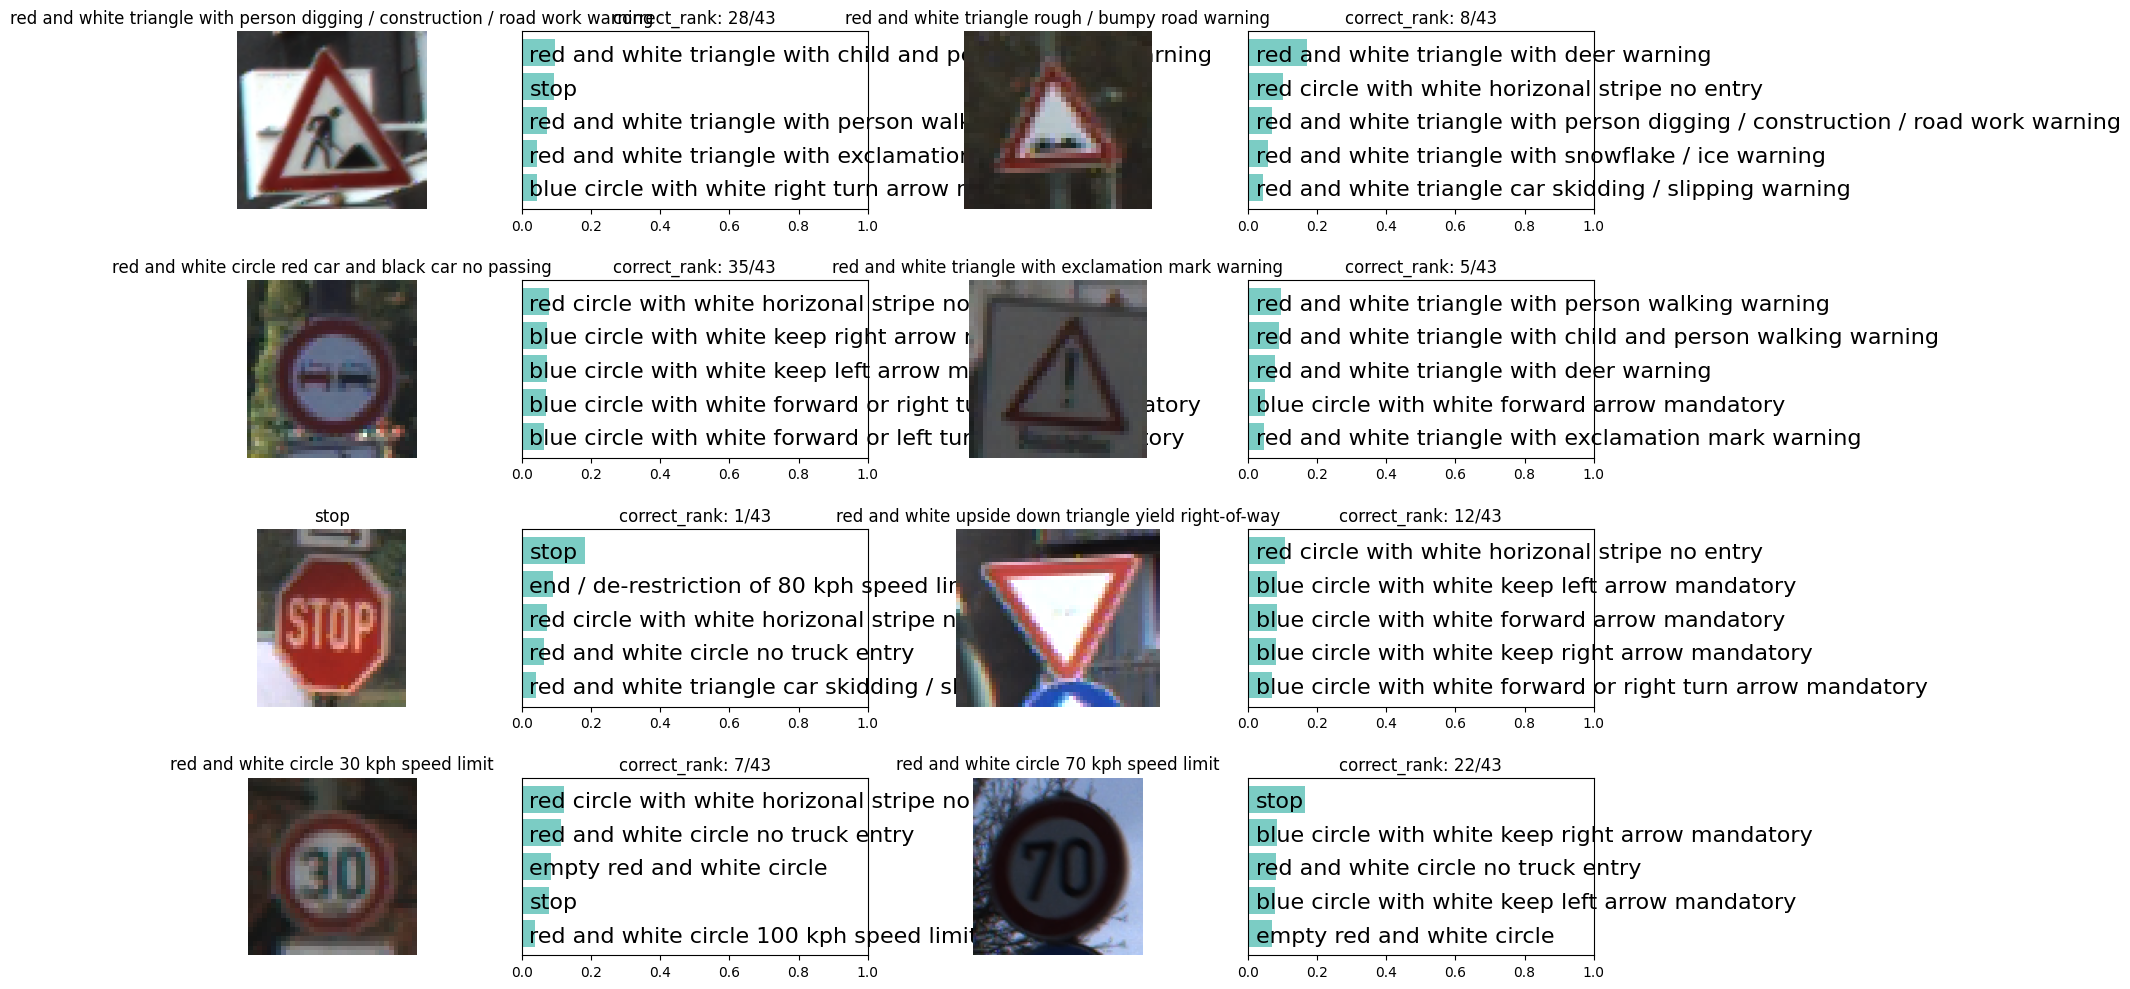

In [22]:
fig, axs = plt.subplots(4,4,figsize=(20,10))
for i in range(8):
    image = original_images[i]
    ax = axs[i%4, 0 + 2*int(i/4)]
    ax.imshow(image)
    title_tex = classnames[image_labels[i]]
    ax.set_title(title_tex)
    ax.axis("off")

    correct_rank = (text_probs.argsort(dim=1, descending=True)[i] == image_labels[i]).nonzero(as_tuple=False).item() + 1

    ax = axs[i%4, 1 + 2*int(i/4)]
    title_tex = f'correct_rank: {correct_rank}/{len(classnames)}'
    ax.set_title(title_tex)
    y = np.arange(top_probs.shape[-1])
    ax.barh(y, top_probs[i], zorder=-1, color=[123/255.0,204/255.0,196/255.0,255/255.0])
    ax.invert_yaxis()
    ax.set_axisbelow(True)
    ax.set_yticks(y)
    ax.set_xlim([0,1])
    ax.yaxis.set_ticks_position('none') 
    ax.tick_params(axis="y", labelsize=16)
    classnames_plot = classnames
    ax.set_yticklabels([classnames_plot[index] for index in top_labels[i].numpy()], x=0.05, zorder=1, horizontalalignment='left')


plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.05)